<a href="https://colab.research.google.com/github/KyDuyenDo/models_rasp_tf/blob/main/danhgiangong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import itertools

# Xác định thư mục chứa ảnh
duyen_folder = "/content/sample_data/duyen"
khacnhau_folder = "/content/sample_data/dif"

# Lấy danh sách tên file ảnh trong mỗi thư mục
duyen_images = [os.path.join(duyen_folder, f) for f in os.listdir(duyen_folder) if f.endswith(".jpg")]
khacnhau_images = [os.path.join(khacnhau_folder, f) for f in os.listdir(khacnhau_folder) if f.endswith(".jpg")]

# Tạo mảng 'duyen' chứa các cặp ảnh từ thư mục 'duyen'
duyen_pairs = list(itertools.combinations(duyen_images, 2))

# Tạo mảng 'khacnhau' chứa các cặp ảnh từ thư mục 'khacnhau'
khacnhau_pairs = list(itertools.combinations(khacnhau_images, 2))

# In ra số lượng cặp ảnh trong mỗi mảng
print(f"Số lượng cặp ảnh Duyên: {len(duyen_pairs)}")
print(duyen_pairs)
print(khacnhau_pairs)
print(f"Số lượng cặp ảnh Khác nhau: {len(khacnhau_pairs)}")

Số lượng cặp ảnh Duyên: 10
[('/content/sample_data/duyen/05.jpg', '/content/sample_data/duyen/06.jpg'), ('/content/sample_data/duyen/05.jpg', '/content/sample_data/duyen/04.jpg'), ('/content/sample_data/duyen/05.jpg', '/content/sample_data/duyen/03.jpg'), ('/content/sample_data/duyen/05.jpg', '/content/sample_data/duyen/02.jpg'), ('/content/sample_data/duyen/06.jpg', '/content/sample_data/duyen/04.jpg'), ('/content/sample_data/duyen/06.jpg', '/content/sample_data/duyen/03.jpg'), ('/content/sample_data/duyen/06.jpg', '/content/sample_data/duyen/02.jpg'), ('/content/sample_data/duyen/04.jpg', '/content/sample_data/duyen/03.jpg'), ('/content/sample_data/duyen/04.jpg', '/content/sample_data/duyen/02.jpg'), ('/content/sample_data/duyen/03.jpg', '/content/sample_data/duyen/02.jpg')]
[('/content/sample_data/dif/05.jpg', '/content/sample_data/dif/04.jpg'), ('/content/sample_data/dif/05.jpg', '/content/sample_data/dif/03.jpg'), ('/content/sample_data/dif/05.jpg', '/content/sample_data/dif/01.jp

In [3]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_

In [6]:
import numpy as np
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [5]:
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device=device,
    selection_method='center_weighted_size'
)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [7]:
def extract_face_vector(img_path):
  """Trích xuất vecto khuôn mặt từ ảnh."""
  img = Image.open(img_path)
  img_cropped = mtcnn(img)
  img_embedding = resnet(img_cropped.unsqueeze(0)).detach()
  return img_embedding

In [8]:
def calculate_distance(vec1, vec2):
  """Tính toán khoảng cách Euclidean giữa hai vecto khuôn mặt."""
  return np.linalg.norm(vec1 - vec2)

In [9]:
def evaluate_performance(pairs_same, pairs_diff, thresholds):
  """Đánh giá hiệu suất FaceNet cho các ngưỡng khoảng cách khác nhau."""
  tar, far = [], []
  for threshold in thresholds:
    true_accepts = 0
    false_accepts = 0
    for pair in pairs_same:
      img1, img2 = pair
      vec1 = extract_face_vector(img1)
      vec2 = extract_face_vector(img2)
      if vec1 is None or vec2 is None:
        continue
      distance = calculate_distance(vec1, vec2)
      if distance <= threshold:
        true_accepts += 1
    for pair in pairs_diff:
      img1, img2 = pair
      vec1 = extract_face_vector(img1)
      vec2 = extract_face_vector(img2)
      if vec1 is None or vec2 is None:
        continue
      distance = calculate_distance(vec1, vec2)
      if distance <= threshold:
        false_accepts += 1
    tar.append(true_accepts / len(pairs_same))
    far.append(false_accepts / len(pairs_diff))
  return tar, far

In [10]:
import matplotlib.pyplot as plt

def plot_roc_curve(tar, far):
  """Vẽ đường cong ROC."""
  plt.plot(far, tar, label="TAR")
  plt.xlabel("FAR")
  plt.ylabel("TAR")
  plt.title("Đường cong ROC")
  plt.grid(True)
  plt.show()


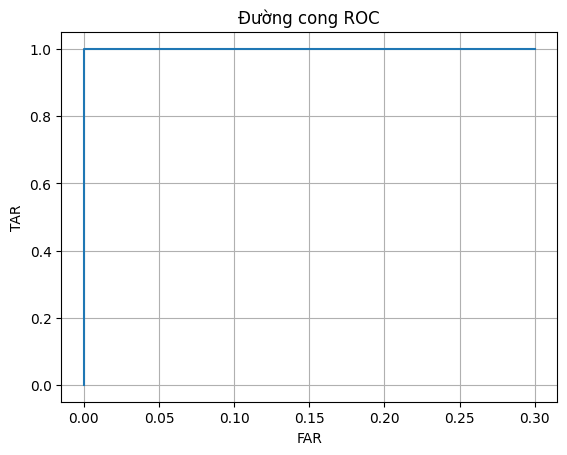

In [11]:
# Đánh giá hiệu suất cho các ngưỡng khác nhau
thresholds = np.arange(0, 1.1, 0.1)
tar, far = evaluate_performance(duyen_pairs, khacnhau_pairs, thresholds)

# Vẽ đường cong ROC
plot_roc_curve(tar, far)


In [12]:
print(tar, far)

[0.0, 0.0, 0.0, 0.2, 0.3, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3]
